In [9]:
%matplotlib widget
# standard python imports
import numpy as np
import matplotlib.pyplot as plt


# Tidy3D imports
import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins.polyslab import ComplexPolySlab
from tidy3d.plugins.mode import ModeSolver
from tidy3d.plugins.mode.web import run as run_mode_solver



In [10]:
# Wavelength and frequency values.
wl_c = 1.55  # Central wavelength.
wl_bw = 0.100  # Wavelength bandwidth.
wl_n = 101  # Number of wavelength points to compute the output data.
wl_range = np.linspace(wl_c - wl_bw / 2, wl_c + wl_bw / 2, wl_n)
freq_c = td.C_0 / wl_c
freq_range = td.C_0 / wl_range
freq_width = 0.5 * (np.max(freq_range) - np.min(freq_range))
run_time = 30 / freq_width


# Material definitions.
mat_LN = td.Medium(permittivity=2.2111**2)  # Taper and substrate material.
mat_sio2 = td.Medium(permittivity=1.444**2)  # Box and cladding material.
mat_air = td.Medium(permittivity=1.00)  # External medium material.

# Gaussian beam
spot_size = 2 

# grid
min_steps_per_wvl = 15


In [11]:
# Taper parameters
para_dic = {
    # width
    'down_left_width': 0.15,
    'down_middle_width': 1.2,
    'down_right_width': 12,
    'up_middle_width': 0.03,
    'up_right_width': 1.5,

    # height
    'down_height': 0.3,
    'up_height': 0.3,

    # length
    'left_length': 80,
    'right_length': 80,

    # angle
    'down_angle': 90-60,
    'up_angle': 90-60,

    # port
    'left_port': 1,
    'right_port': 1,

    # taper shape
    'taper_shape_lst': ['linear','linear','linear']
}

locals().update(para_dic)


In [12]:
# Simulation domain parameters.
size_x = left_length+right_length+left_port+right_port
size_y = 30
size_z = 3

In [13]:
def get_xy(taper_shape,x_lim,y_lim,Nx = 1001):
    # x: waveguide propagation direction
    # y: waveguide width
    x0,x1 = x_lim
    y0,y1 = y_lim
    x = np.linspace(x0, x1, Nx)
    if taper_shape == "quadratic":
        alpha = ((x - x0) / (x1 - x0)) ** 2
    elif taper_shape == "exponential":
        alpha = np.expm1((x - x0) / (x1 - x0)) / np.expm1(1)
    elif taper_shape == "linear":
        alpha = (x - x0) / (x1 - x0)
    else:
        raise ValueError("Unknown taper shape.")
    y = y0 + alpha * (y1 - y0)
    return (x,y)

In [14]:
def get_a_taper(taper_shape,x_lim,y_lim,h0,height,angle,Nx = 101):
    (x,y) = get_xy(taper_shape,x_lim,y_lim,Nx)
    upper_bound = [[xv, yv] for xv, yv in zip(x, y)]
    lower_bound = [[xv, -yv] for xv, yv in zip(x[::-1], y[::-1])]
    taper_polygon = upper_bound + lower_bound

    s =  ComplexPolySlab(
            vertices=taper_polygon, axis=2, slab_bounds=(h0-height / 2,h0+height / 2),sidewall_angle =angle/180*np.pi,reference_plane='top')
    # Inverted taper structure using a PolySlab.
    taper = td.Structure(
        geometry=s.geometry_group,
        medium=mat_LN,
    )
    return taper
    

In [15]:
def get_taper_structures(p):
    down_left_taper = get_a_taper(p['taper_shape_lst'][0],
        x_lim = (p['left_port'],p['left_port']+p['left_length']), 
            y_lim = (p['down_left_width'],p['down_middle_width']), h0 = 0,height = p['down_height'],angle = p['down_angle'])
    
    down_right_taper = get_a_taper(p['taper_shape_lst'][1],
        x_lim = (p['left_port']+p['left_length'],p['left_port']+p['left_length']+p['right_length']), 
            y_lim = (p['down_middle_width'],p['down_right_width']), h0 = 0,height = p['down_height'],angle = p['down_angle'])
    
    up_taper = get_a_taper(p['taper_shape_lst'][2],x_lim = (p['left_port']+p['left_length'],p['left_port']+p['left_length']+p['right_length']), 
            y_lim = (p['up_middle_width'],p['up_right_width']), h0 = p['down_height'],height = p['up_height'],angle = p['down_angle'])
    
    return down_left_taper,down_right_taper,up_taper

In [16]:
def get_simulations(p):
    down_left_taper,down_right_taper,up_taper = get_taper_structures(p)
    #left_port,right_port = get_ports(p)
    
    gauss_source = td.GaussianBeam(
        center=(0.01, 0, 0),
        size=(0, size_y, size_z),
        source_time=td.GaussianPulse(freq0=freq_c, fwidth=freq_width),
        pol_angle=0,
        direction="+",
        num_freqs=7,
        waist_radius=spot_size,
    )
    
    # Define the mode monitor.
    mode_spec = td.ModeSpec(num_modes=1)
    mode_monitor = td.ModeMonitor(
        center=(p['left_port']+p['left_length']+p['right_length']-0.01, 0, 0),
        size=(0, size_y, size_z),
        freqs=freq_range,
        mode_spec=mode_spec,
        name="mode_0",
    )

    # Define the simulation
    sim = td.Simulation(
                center=(size_x / 2, 0, 0),
                size=(size_x, size_y, size_z),
                medium=mat_sio2,
                grid_spec=td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl, wavelength=wl_c),
                sources=[gauss_source],
                structures=[down_left_taper,down_right_taper,up_taper],
                monitors=[mode_monitor],
                boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML(num_layers=20)),
                run_time=run_time,
            )
    return sim
    

In [17]:
sim_tap = {}
for shape in ['linear','quadratic','exponential']:
    p_now = para_dic.copy()
    p_now['taper_shape_lst'] = [shape,shape,shape]
    sim = get_simulations(p_now)
    sim_tap[shape] = sim

In [18]:
sim_tap['linear'].plot_3d()

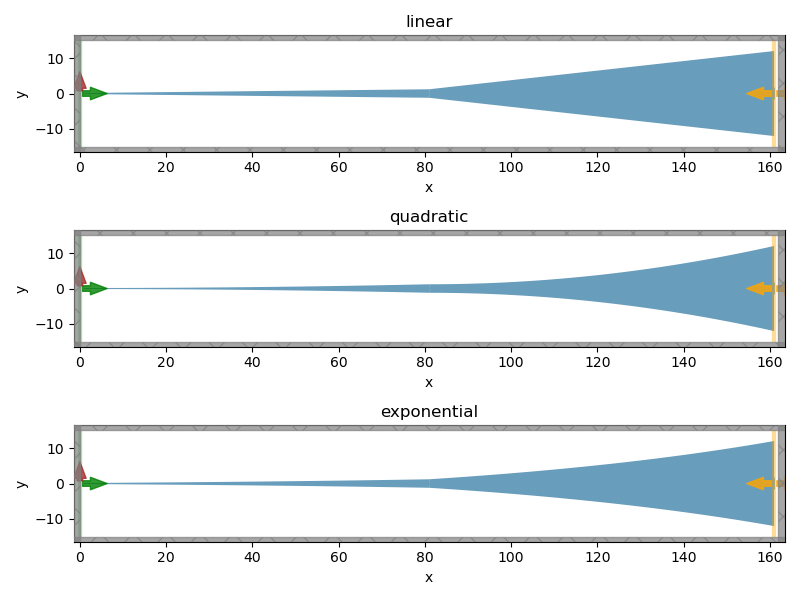

In [19]:
# Structure visualization.
fig, axs = plt.subplots(3, 1, tight_layout=True, figsize=(8, 6))
for sim_s, tap_n, ax in zip(sim_tap.values(), sim_tap.keys(), axs):
    sim_s.plot(z=para_dic['down_height']/2, ax=ax)
    ax.set_aspect("auto")  # Used to better visualize the shapes.
    ax.set_title(tap_n)
plt.show()


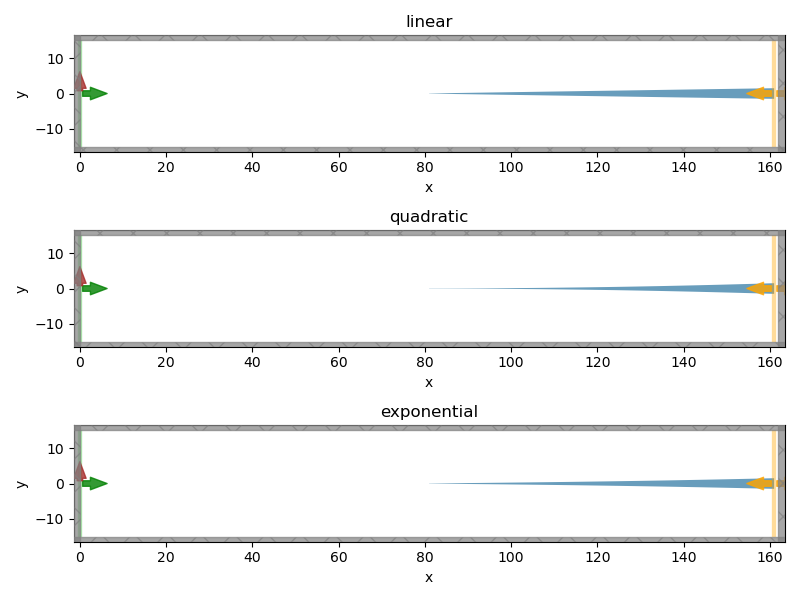

In [20]:
# Structure visualization.
fig, axs = plt.subplots(3, 1, tight_layout=True, figsize=(8, 6))
for sim_s, tap_n, ax in zip(sim_tap.values(), sim_tap.keys(), axs):
    sim_s.plot(z=para_dic['up_height']/2+para_dic['down_height'], ax=ax)
    ax.set_aspect("auto")  # Used to better visualize the shapes.
    ax.set_title(tap_n)
plt.show()

In [12]:
# Initialize a simulation batch.
batch = web.Batch(simulations=sim_tap, verbose=True)

# Get the estimated simulation cost.
tot_cost = 0
for bat in batch.get_info().values():
    sim_name = bat.taskName
    cost = web.estimate_cost(bat.taskId)
    tot_cost += cost
    print(f"Estimated FlexCredit cost for {sim_name} = {cost:.2f}")
print(f"Total estimated FlexCredit cost for batch = {tot_cost:.2f}")


[23:41:39] Created task 'linear' with task_id                                   
           'fdve-443809aa-b2d5-439b-97ec-98f17a92fd48v1'.

           View task using web UI at                                            
           ]8;id=732113;https://tidy3d.simulation.cloud/workbench?taskId=fdve-443809aa-b2d5-439b-97ec-98f17a92fd48v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=827326;https://tidy3d.simulation.cloud/workbench?taskId=fdve-443809aa-b2d5-439b-97ec-98f17a92fd48v1\taskId]8;;\]8;id=732113;https://tidy3d.simulation.cloud/workbench?taskId=fdve-443809aa-b2d5-439b-97ec-98f17a92fd48v1\=]8;;\]8;id=250720;https://tidy3d.simulation.cloud/workbench?taskId=fdve-443809aa-b2d5-439b-97ec-98f17a92fd48v1\fdve]8;;\]8;id=732113;https://tidy3d.simulation.cloud/workbench?taskId=fdve-443809aa-b2d5-439b-97ec-98f17a92fd48v1\-443809aa-b2d5-]8;;\
           ]8;id=732113;https://tidy3d.simulation.cloud/workbench?taskId=fdve-443809aa-b2d5-439b-97ec-98f17a92fd48v1\439b-97ec-98f17a92fd48v1']8;;\.

Output()

[23:41:40] Created task 'quadratic' with task_id                                
           'fdve-b91fa566-f16e-4a83-b680-4c784173fe10v1'.

           View task using web UI at                                            
           ]8;id=272053;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b91fa566-f16e-4a83-b680-4c784173fe10v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=556960;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b91fa566-f16e-4a83-b680-4c784173fe10v1\taskId]8;;\]8;id=272053;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b91fa566-f16e-4a83-b680-4c784173fe10v1\=]8;;\]8;id=278296;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b91fa566-f16e-4a83-b680-4c784173fe10v1\fdve]8;;\]8;id=272053;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b91fa566-f16e-4a83-b680-4c784173fe10v1\-b91fa566-f16e-]8;;\
           ]8;id=272053;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b91fa566-f16e-4a83-b680-4c784173fe10v1\4a83-b680-4c784173fe10v1']8;;\.

Output()

[23:41:41] Created task 'exponential' with task_id                              
           'fdve-19ffd0a3-287b-4309-ae45-386f521df324v1'.

           View task using web UI at                                            
           ]8;id=616291;https://tidy3d.simulation.cloud/workbench?taskId=fdve-19ffd0a3-287b-4309-ae45-386f521df324v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=446029;https://tidy3d.simulation.cloud/workbench?taskId=fdve-19ffd0a3-287b-4309-ae45-386f521df324v1\taskId]8;;\]8;id=616291;https://tidy3d.simulation.cloud/workbench?taskId=fdve-19ffd0a3-287b-4309-ae45-386f521df324v1\=]8;;\]8;id=51189;https://tidy3d.simulation.cloud/workbench?taskId=fdve-19ffd0a3-287b-4309-ae45-386f521df324v1\fdve]8;;\]8;id=616291;https://tidy3d.simulation.cloud/workbench?taskId=fdve-19ffd0a3-287b-4309-ae45-386f521df324v1\-19ffd0a3-287b-]8;;\
           ]8;id=616291;https://tidy3d.simulation.cloud/workbench?taskId=fdve-19ffd0a3-287b-4309-ae45-386f521df324v1\4309-ae45-386f521df324v1']8;;\.

Output()

Estimated FlexCredit cost for linear = 3.46
Estimated FlexCredit cost for quadratic = 3.46
Estimated FlexCredit cost for exponential = 3.46
Total estimated FlexCredit cost for batch = 10.39


In [13]:
batch_taper = batch.run(path_dir="data/data_taper")
sim_tap_results = {tl: sn for tl, sn in batch_taper.items()}


[23:41:45] Started working on Batch.

[23:41:47] Maximum FlexCredit cost: 10.390 for the whole batch. Use             
           'Batch.real_cost()' to get the billed FlexCredit cost after the Batch
           has completed.

Output()

[23:45:18] Batch complete.

Output()

[23:45:20] loading SimulationData from                                          
           data/data_taper/fdve-443809aa-b2d5-439b-97ec-98f17a92fd48v1.hdf5

Output()

[23:45:22] loading SimulationData from                                          
           data/data_taper/fdve-b91fa566-f16e-4a83-b680-4c784173fe10v1.hdf5

Output()

[23:45:23] loading SimulationData from                                          
           data/data_taper/fdve-19ffd0a3-287b-4309-ae45-386f521df324v1.hdf5

In [17]:
batch.real_cost()

7.8960715333476825

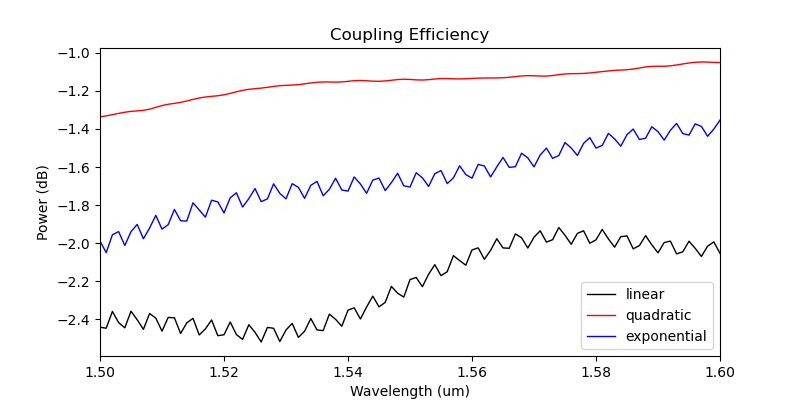

In [28]:
power_tap_25 = []
for sim_data in sim_tap_results.values():
    mode_amps = sim_data["mode_0"]
    coeffs_f = mode_amps.amps.sel(direction="+")
    power_0 = np.abs(coeffs_f.sel(mode_index=0)) ** 2
    power_0_db = 10 * np.log10(power_0)
    power_tap_25.append(power_0_db)

plot_colors = ("black", "red", "blue")
fig, ax1 = plt.subplots(1, figsize=(8, 4))
for data, color, label in zip(power_tap_25, plot_colors, sim_tap_results.keys()):
    ax1.plot(
        wl_range,
        data,
        color=color,
        linestyle="solid",
        linewidth=1.0,
        label=label,
    )
ax1.set_xlim([wl_range[0], wl_range[-1]])
ax1.set_xlabel("Wavelength (um)")
ax1.set_ylabel("Power (dB)")
ax1.set_title("Coupling Efficiency")
plt.legend()
plt.savefig('data/taper.png',dpi = 300)
plt.show()
